In [97]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from matplotlib.ticker import AutoMinorLocator

### Overview

The purpose of this notebook is to convert driven depth to cone resistance (qd). To facilitate the comparison of Panda and DCP data and allow correlations from qd to other geotechnical properties to be calculated. First, the function to calculate qd from physical properties of the DCP, driven depth on each blow, and impact energy is defined. Second, the DCP and Panda data is read in and processed. Finally, Panda data is used to provide comaprisons between the DCP qd values and Panda qd values. 

#### Functions

In [98]:
# Functions
def calc_qd(A, E, e, P, M):
    # Defs of variables
    # A: Area
    # E: variable energy from each blow
    # e: measured depth of each blow
    # P: weight of the driven system
    # M: weight of the hammer
    qd = (1/A) * (E/e) * (1/(1 + P/M))
    return qd

# def calc_qdFromCBR(CBR):
#     #Formula from Langton page 11
#     #Original formula was to calculate CBR from qd in (MPa)
#     qd = 10**((np.log10(CBR) - 0.352)/1.057)
#     return qd #(MPa)

def calcDynamicWeight(Total_Driven_Depth, perc_Rod_inGround, rod_Weight, rod_Length, DCP_Sys_Weight):
    # Initialize array to store rod system weights not including the hammer
    # This a function of the number of rods in use
    Ps = np.zeros(len(Total_Driven_Depth))

    #Calc depth that a rod is added to the DCP
    add_depth = perc_Rod_inGround * rod_Length

    # Init index for the number of rods added
    num_Rod = 0
    
    # Loop though all depths and determine when the weight of the DCP system increased and add rod weight
    for i, depth in enumerate(Total_Driven_Depth):
        
        # Calc current weight
        current_weight = DCP_Sys_Weight + num_Rod * rod_Weight
        
        #Check if current depth is greater than the set depth to add a rod (add_depth)
        if depth > add_depth:
            # Add a rod to the system
            num_Rod+=1

            # Update the current system weight
            current_weight = DCP_Sys_Weight + num_Rod * rod_Weight

            # Update weight array with current weight
            Ps[i] = current_weight

            # Increase the depth a rod should be added 
            add_depth = add_depth + perc_Rod_inGround * rod_Length
        else:
            # Update the current system weight
            Ps[i] = current_weight
    # Return array of weights
    return Ps


#### Read in data

##### Directories and sheets to read in

In [99]:
# Panda sheet names to collect
Panda_sheet_names = ["A", "C", "E", "F"]

# Dir to Excel containing Panda data
Panda_Data_dir = r"C:\Users\u4hncjjm\Documents\Research\Panda_DCP\GTM-South_PandaData.xlsx"

# DCP sheet names to collect 
DCP_sheet_names = ["A2", "C", "E", "F"]

# Dir to Excel file containing DCP
DCP_Data_dir = r"C:\Users\u4hncjjm\Documents\Research\Panda_DCP\GTM-South_DCPData.xlsx"

##### Read in DCP data

In [100]:
# Read in DCP data
# setting sheet_name = None reads in all sheets in DCP_Data_dir and stores each as an element of a dictionary
DCP_df_dict = pd.read_excel(DCP_Data_dir, sheet_name= DCP_sheet_names)

# Init list to store DCP qds (Not yet calculated)
DCP_qds = [0] * len(DCP_sheet_names)

# Init list to store DCP delta driven depths
DCP_Delta_Depths = [0] * len(DCP_sheet_names)

# Init list to store DCP Total driven depths
DCP_Total_Depths = [0] * len(DCP_sheet_names)

# Collect DCP depths
for i, name in enumerate(DCP_sheet_names):
    # Select sheet and collect depth data
    Total_Driven_Depth = DCP_df_dict[name]["Depth (mm)"]

    #Convert to meters
    Total_Driven_Depth = Total_Driven_Depth * 1e-3 #[m]

    # Temporarily store first driven value
    dummy_val = Total_Driven_Depth.iloc[0]

    #Store total driven depths
    DCP_Total_Depths[i] = Total_Driven_Depth

    # Calc incremental driven depths
    delta_Depth = Total_Driven_Depth.diff()

    # Store first driven depth
    delta_Depth.iloc[0] = dummy_val

    #Store driven depth in list
    DCP_Delta_Depths[i] = np.array(delta_Depth)

# print(DCP_delta_Depths)

##### Read in and get Panda data

In [101]:
# Read in DCP data as dictionary of dfs
# setting sheet_name = None reads in all sheets in Panda_Data_dir
Panda_df_dict = pd.read_excel(Panda_Data_dir, sheet_name= Panda_sheet_names)

# Init list to store panda qd values
Panda_qds = [0]* len(Panda_sheet_names)

# Init list to store panda depths
Panda_Depths = [0] * len(Panda_sheet_names)

# Collect Panda depths and qd values
for i, name in enumerate(Panda_sheet_names):
    Panda_qds[i] = np.array(Panda_df_dict[name]["qd (MPa)"])
    Panda_Depths[i] = np.array(Panda_df_dict[name]["Depth (m)"])

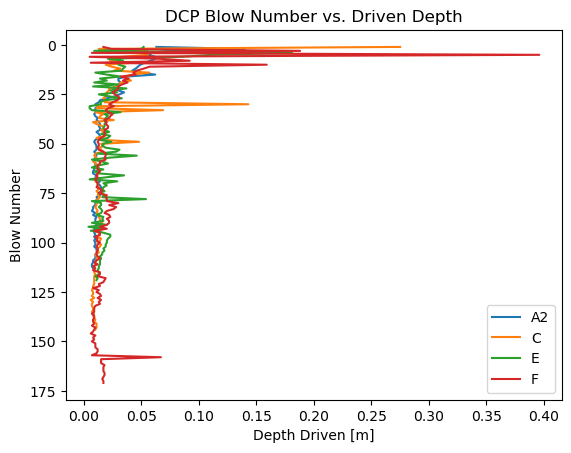

In [102]:
# Plot Blow Number vs. incremental driven depth
for i, depths in enumerate(DCP_Delta_Depths):
    BlowCount = np.linspace(1, len(depths), len(depths))
    plt.plot(depths, BlowCount, label = DCP_sheet_names[i])
plt.gca().invert_yaxis()
plt.xlabel("Depth Driven [m]")
plt.ylabel("Blow Number")
plt.title("DCP Blow Number vs. Driven Depth")
plt.legend(loc = "lower right")
plt.show()

#### Define constants for DCP qd calc

In [103]:
# Constants
g = 9.81 #[m/s^2]

# Drop height of the hammer (referenced from anvil height)
dropHeight = 0.674 #[m]

# DCP cone radius
coneRadius = 0.02 #[m]

### DCP Eqn values
# Cone Cross-sectional area
A = np.pi * coneRadius**2 #[m^2]

# Weight of DCP Hammer, should be 
HammerWeight = (1.94 + 3.37) * g #[N]

# Calc Hammer Potential Energy at drop height
E = HammerWeight * dropHeight #[J]

#### Assign DCP weight properties

In [113]:
### DCP weight constants

# Weight of one rod
rod_Weight = 0.93 * g #[N]

# Length of one rod
rod_Length = 0.5 #[m]

# Weight of base DCP setup, base rod mass + Hammer mass + clip mass
DCP_Sys_Weight = (1.97 + 2.866)  * g #[N]

# Assume Percentage of rod in ground before adding another rod
perc_Rod_inGround = 0.85 #[-]

#### Determine DCP Dynamic weight and qd

In [114]:
# Loop through the delta_depths at each station, calc qd, convert to MPa
for i, depths in enumerate(DCP_Delta_Depths):
    # Determine weight of rod system inclding weight from added rods
    Ps = calcDynamicWeight(DCP_Total_Depths[i], perc_Rod_inGround, rod_Weight, rod_Length, DCP_Sys_Weight) #[N]
    
    # Calc qd and convert to MPa
    DCP_qds[i] = calc_qd(A, E, depths, Ps, HammerWeight) * 1e-6 #[MPa]
    # print(DCP_qds[i])

#### Plot Data

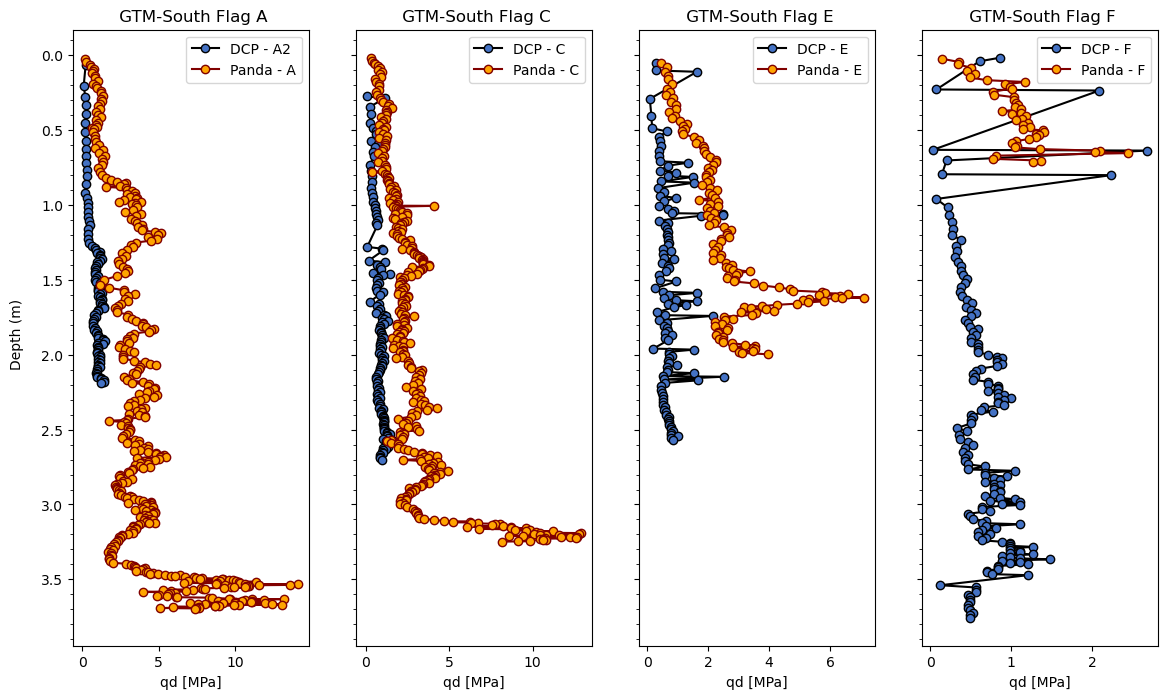

In [115]:
fig, axs = plt.subplots(nrows = 1, ncols= len(DCP_sheet_names), figsize=(14,8), sharey=True, )

# Creat common y label for subplots (0.08, 0.5) -> (x, y)
fig.text(0.08, 0.5, 'Depth (m)', va='center', rotation='vertical')

# Plot DCP data
for i in range(len(DCP_sheet_names)):
    axs[i].plot(DCP_qds[i], DCP_Total_Depths[i], "k", marker = ".", markerfacecolor="#4472C4", markersize = 12, label = "DCP - " + DCP_sheet_names[i])
    axs[i].plot(Panda_qds[i], Panda_Depths[i], "maroon", marker = ".", markerfacecolor="orange", markersize = 12, label = "Panda - " + Panda_sheet_names[i])

    # Format plots
    axs[i].yaxis.set_minor_locator(AutoMinorLocator(5))
    axs[i].set_title(" GTM-South Flag " + Panda_sheet_names[i])
    # axs[i].set_ylabel("Depth [m]")
    axs[i].set_xlabel("qd [MPa]")
    
    axs[i].legend()
# Plot Panda data
axs[0].invert_yaxis()

# ax.set_xlim(0,5)
plt.show()

In [107]:
def calc_qd(A, E, e, P, M):
    # Defs of variables
    # A: Area
    # E: variable energy from each blow
    # e: measured depth of each blow
    # P: weight of the driven system
    # M: weight of the hammer
    qd = (1/A) * (E/e) * (1/(1 + P/M))
    return qd

In [108]:
help(plt.subplots)

Help on function subplots in module matplotlib.pyplot:

subplots(nrows=1, ncols=1, *, sharex=False, sharey=False, squeeze=True, width_ratios=None, height_ratios=None, subplot_kw=None, gridspec_kw=None, **fig_kw)
    Create a figure and a set of subplots.
    
    This utility wrapper makes it convenient to create common layouts of
    subplots, including the enclosing figure object, in a single call.
    
    Parameters
    ----------
    nrows, ncols : int, default: 1
        Number of rows/columns of the subplot grid.
    
    sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
        Controls sharing of properties among x (*sharex*) or y (*sharey*)
        axes:
    
        - True or 'all': x- or y-axis will be shared among all subplots.
        - False or 'none': each subplot x- or y-axis will be independent.
        - 'row': each subplot row will share an x- or y-axis.
        - 'col': each subplot column will share an x- or y-axis.
    
        When subplots 

In [109]:
# Import the driven depths

path = r'' # use your path
all_files = glob.glob(os.path.join(path , "/*.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

e_frame = pd.concat(li, axis=0, ignore_index=True)

ValueError: No objects to concatenate

Help on tuple object:

class tuple(object)
 |  tuple(iterable=(), /)
 |  
 |  Built-in immutable sequence.
 |  
 |  If no argument is given, the constructor returns an empty tuple.
 |  If iterable is specified the tuple is initialized from iterable's items.
 |  
 |  If the argument is a tuple, the return value is the same object.
 |  
 |  Built-in subclasses:
 |      asyncgen_hooks
 |      UnraisableHookArgs
 |  
 |  Methods defined here:
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __getnewargs__(self, /)
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |      Return hash(self).
 |  
 |  __iter__(self, /)
 |

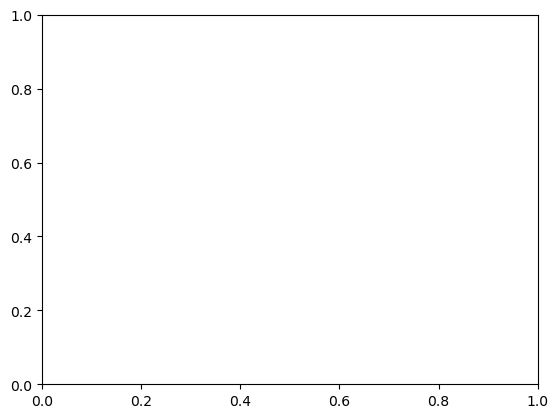

In [ ]:
help(plt.yticks())